<a href="https://colab.research.google.com/github/cartiktq/GenAI/blob/main/ABSC_Classification_with_LLM_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aspect-Based Sentiment Classification Walkthrough

In this notebook, we will explore the process of using LangChain with a large language model (LLM) for aspect-based sentiment classification (ABSC). ABSC is a granular approach to sentiment analysis that determines the sentiment (positive, negative, or neutral) toward specific aspects or attributes within a piece of text.

For example, in the sentence:
> "The food at the restaurant was delicious, but the service was slow."

The sentiment toward the aspect *"food"* is positive, while the sentiment toward the aspect *"service"* is negative.

### Outline

In this walkthrough, we will:

1. **Load an ABSC Dataset:** Read in a dataset specifically designed for aspect-based sentiment classification. We will use the SemEval 2014 Dataset, which can be downloaded in  handy csv file from [Kaggle](https://www.kaggle.com/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis?select=Laptop_Train_v2.csv)
2. **Build an LLM Using LangChain and HuggingFace:** Configure the large language model to handle sentiment classification tasks.
3. **Craft a Labeling Prompt:** Create a well-structured prompt to guide the LLM in identifying sentiment for specific aspects of text.
4. **Classify Dataset Examples:** Use the LLM and the prompt to classify examples in the dataset.
5. **Evaluate Performance:** Measure classification accuracy using evaluation metrics such as precision, recall, and F1 score.

### Example

To understand ABSC better, let’s consider this example:

```python
review = "The laptop's performance is outstanding, but the battery life is disappointing."
aspects = ["performance", "battery life"]
```

The expected output is:

| Aspect         | Sentiment   |
|----------------|-------------|
| Performance    | Positive    |
| Battery Life   | Negative    |

By the end of this notebook, you'll learn how to apply ABSC with LLMs to solve similar problems effectively.


# Configure the Environment

In [4]:
! pip install pandas
! pip install langchain
! pip install transformers
! pip install langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Read in dataset and investigate the data

Make sure to download the data from [Kaggle](https://www.kaggle.com/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis?select=Laptop_Train_v2.csv). We'll be working with the ```Laptop_Train_v2.csv```

__Prompt__: I would like the python code to read in python dataframe from a csv named "Laptop_Train_v2.csv". I would like for you to downsample to 100 entries from the dataframe. Note that for the sampling, use the column 'id' to determine samples. So, there should be 100 unique values of 'id', but there will be more than 100 rows. I would like to also have the code to view the column names, a sample of the entries and summary of the values in each column.

In [8]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Read CSV file into a DataFrame
file_name = "/content/drive/MyDrive/KaggleDatasets/SemEval2014/Laptop_Train_v2.csv"
df = pd.read_csv(file_name)
print("CSV file successfully loaded!")

# Downsample to 100 unique 'id' values
sampled_ids = df['id'].drop_duplicates().sample(n=100)  # Randomly select 100 unique IDs
df_sampled = df[df['id'].isin(sampled_ids)]

# View column names
print("Column Names:")
print(df.columns.tolist())

# View a sample of entries
print("\nSample of entries:")
print(df_sampled.sample(5))

# Summary statistics
print("\nSummary of values:")
print(df_sampled.describe(include='all'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file successfully loaded!
Column Names:
['id', 'Sentence', 'Aspect Term', 'polarity', 'from', 'to']

Sample of entries:
        id                                           Sentence    Aspect Term  \
1317   145  But after using it a couple of weeks, the over...      operation   
966   1075  It could be a perfect laptop if it would have ...  system memory   
1169  3082  This is not a serious gaming laptop or a serio...         gaming   
999   2213  I use iphoto all the time, which is a great pr...        program   
1089  1993  Whenever tried to turn it on, it would restart...           BIOS   

      polarity  from  to  
1317  negative    50  59  
966   negative    53  66  
1169  negative    22  28  
999   positive    44  51  
1089  negative    62  66  

Summary of values:
                 id                                           Sentence  \
count    1

__prompt__: Okay, now please give me the python code to look at the unique values, along with their counts of the "polarity" and the "Aspect Term" columns from the dataframe 'df'. You do not need to check for the columns or dataframe; they are already loaded in.

In [2]:
# Unique values and their counts for 'polarity'
print("Polarity Value Counts:")
print(df_sampled['polarity'].value_counts(dropna=False))

# Unique values and their counts for 'Aspect Term'
print("\nAspect Term Value Counts:")
print(df_sampled['Aspect Term'].value_counts(dropna=False))

Polarity Value Counts:
polarity
negative    63
positive    57
neutral     25
conflict     7
Name: count, dtype: int64

Aspect Term Value Counts:
Aspect Term
screen                   7
battery                  6
keyboard                 4
use                      4
hard drive               4
                        ..
call center              1
Garmin GPS software      1
Microsoft Office 2003    1
mac osx                  1
operating system         1
Name: count, Length: 123, dtype: int64


# Instantiate a LLM for Classification

__prompt__: Now, I need you to create an LLM object using LangChain. In particular, I would like to use the text-generation model of "tiiuae/Falcon3-3B-Instruct" from HuggingFace and use the 0th GPU. Make sure to import the langchain HuggingFace pipeline as "from langchain_huggingface import HuggingFacePipeline". Also, make sure when creating the pipeline to specify "max_new_tokens = 500", and make sure the pipeline only outputs the generated text and not the prompt.

In [2]:
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

# Define model name
model_name = "tiiuae/falcon3-3b-instruct"

# Load tokenizer and model with memory-efficient settings
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Automatically assigns layers to CPU/GPU
    torch_dtype=torch.float16  # Use half-precision for lower memory
)

# Create the pipeline
text_gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=500,
    return_full_text=False
)

# Wrap in LangChain LLM
llm = HuggingFacePipeline(pipeline=text_gen_pipeline)

tokenizer_config.json:   0%|          | 0.00/365k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/658 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

Device set to use cuda:0


In [3]:
llm("Say Hello")

<ipython-input-3-572ef6d98a2d>:1: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  llm("Say Hello")


'" button.\n\n**Step 1: Understanding the Problem**\n\nYou are a helpful assistant that follows instructions to solve tasks. In this case, the task is to write a Python program that prints "Hello World!" when a button is clicked.\n\n**Step 2: Setting Up the Environment**\n\nTo write and run Python code, you need a Python environment. If you don\'t have one installed, you can download it from the official Python website (https://www.python.org/).\n\n**Step 3: Writing the Python Code**\n\nOpen a text editor or an Integrated Development Environment (IDE) like PyCharm, Jupyter Notebook, or even a simple text file. Write the following Python code:\n\n```python\nimport tkinter as tk\n\ndef print_hello():\n    print("Hello World!")\n\nroot = tk.Tk()\nbutton = tk.Button(root, text="Hello", command=print_hello)\nbutton.pack()\n\nroot.mainloop()\n```\n\n**Step 4: Explanation of the Code**\n\n- `import tkinter as tk`: This line imports the Tkinter module, which is a standard Python library for cr

In [4]:
llm.invoke("What is the sentiment of this statement: Also kinda loud when the fan was running")

'.\n<|assistant|>\nThis statement does not express a clear sentiment. It is a neutral observation about the sound level of the fan when it was running.'

# Label the Aspects and Sentiments

Now, we need to label the aspects and sentiments in the data. We first need to create an aspect sentiment labeling prompt

__prompt__: I would like a prompt, formatted as a langchain prompt object, that does aspect-based sentiment classification of a laptop review. The prompt takes in a review of a laptop called {sentence} and does two things. First, it needs to determine what aspects are mentioned in the review. Examples include: 'screen', 'battery life', 'packaging', 'graphics', 'warranty', 'price', 'features'. Each review should have between 1 and 4 aspects, and aspects are usually only one or two word phrases from the review text that describe the laptop. Aspects are usually nouns, and not adverbs or adjectives like "died" or "perfect".

Then for each aspect that is in the review - and only those aspects - it needs to provide the sentiment of the review towards that aspect. The possible sentiment values are "positive", "negative", "neutral", and "conflict". The prompt should also specify that the output should be of the form of a list of tuples, where the first entry in the tuple is the aspect, and second entry is the sentiment of the review towards that aspect. The prompt should also specify that the LLM should only output this list of tuples and no other words. So, as an example:

sentence: "The Macbook arrived in a nice twin packing and sealed in the box, all the functions works great."
output: [('functions', 'positive'),('packaging', 'positive')]

sentence: "The USB port never worked"
output: [('USB port', 'negative')]

sentence: "The price and features more than met my needs."
output: [('price', 'positive'), ('features', 'positive')]

sentence: "My warranty ran out right as the screen died."
output: [('warranty', 'negative'), ('screen', 'negative')]

sentence: "The battery has standard life and the shipping was fast."
output: [('battery', 'neutral'), ('shipping', 'positive')]

sentence: "Just a black screen!"
output: [('screen', 'negative')]

In [5]:
from langchain.prompts import PromptTemplate

# Define the template for aspect-based sentiment classification
template = """
You are an AI that analyzes laptop reviews and determines the sentiment towards various aspects mentioned in the review.

Given a review sentence, do the following:
1. Identify the aspects mentioned in the review. Aspects are typically nouns, usually one or two words, and represent features of the laptop (such as 'screen', 'battery life', 'packaging', 'graphics', 'warranty', 'price', 'features'). There should be between 1 and 4 aspects mentioned in the review.
2. For each identified aspect, determine the sentiment expressed in the review towards that aspect. The possible sentiments are 'positive', 'negative', 'neutral', or 'conflict'.
3. Provide the output as a list of tuples, where the first entry in the tuple is the aspect, and the second entry is the sentiment towards that aspect.

The output should only be the list of tuples with the aspects and sentiments and nothing else. Below are some examples:

Example 1:
Input: "The Macbook arrived in a nice twin packing and sealed in the box, all the functions works great."
Output: [('functions', 'positive'), ('packaging', 'positive')]

Example 2:
Input: "The USB port never worked."
Output: [('USB port', 'negative')]

Example 3:
Input: "The price and features more than met my needs."
Output: [('price', 'positive'), ('features', 'positive')]

Example 4:
Input: "My warranty ran out right as the screen died."
Output: [('warranty', 'negative'), ('screen', 'negative')]

Example 5:
Input: "The battery has standard life and the shipping was fast."
Output: [('battery', 'neutral'), ('shipping', 'positive')]

Example 6:
Input: "Just a black screen!"
Output: [('screen', 'negative')]

Input: "{sentence}"
Output:
"""

# Create the LangChain prompt object
prompt = PromptTemplate(input_variables=["sentence"], template=template)

# Example usage
sentence = "The battery life was long, but the screen quality was disappointing."
formatted_prompt = prompt.format(sentence=sentence)
print(formatted_prompt)



You are an AI that analyzes laptop reviews and determines the sentiment towards various aspects mentioned in the review.

Given a review sentence, do the following:
1. Identify the aspects mentioned in the review. Aspects are typically nouns, usually one or two words, and represent features of the laptop (such as 'screen', 'battery life', 'packaging', 'graphics', 'warranty', 'price', 'features'). There should be between 1 and 4 aspects mentioned in the review.
2. For each identified aspect, determine the sentiment expressed in the review towards that aspect. The possible sentiments are 'positive', 'negative', 'neutral', or 'conflict'.
3. Provide the output as a list of tuples, where the first entry in the tuple is the aspect, and the second entry is the sentiment towards that aspect.

The output should only be the list of tuples with the aspects and sentiments and nothing else. Below are some examples:

Example 1:
Input: "The Macbook arrived in a nice twin packing and sealed in the bo

In [9]:
example = df.iloc[10,:]

print(example['Sentence'])

llm(prompt.format(sentence=example['Sentence']))

I even got my teenage son one, because of the features that it offers, like, iChat, Photobooth, garage band and more!


"<|assistant|>\n[('features', 'positive')]"

Now that we have our labeling prompt, lets construct our labeling chain.

__prompt__: Now, given the LangChain prompt template "prompt", please give me the code to create a langchain chain using the pipe operator "|" with the prompt and an LLM called "llm". Please also create function to parse the output and remove extraneous output from the llm. Below are some examples:

'\n<|assistant|>\n[output] "[\'hardware\', \'positive\'], [\'shipping\', \'negative\']"' -> [('hardware', 'positive'), ('shipping', 'negative')]
"<|assistant|>\n['camera', 'neutral']" -> [('camera', 'neutral')]
"<|assistant|>\n[['graphics', 'positive']], " -> [('graphics', 'positive')]
"<|assistant|>\n[('touchpad', 'positive')]" -> [('touchpad', 'positive')]
"<|assistant|>\nsomething nonsensical, " -> [('','')]

The chain should resemble: label_prompt | llm | parse_output

In [10]:
import ast

# Function to parse the LLM output and remove extraneous content
def parse_output(output: str):
    try:
        # Extract the list of tuples from the LLM output, which could be wrapped in extra characters
        parsed_output = ast.literal_eval(output.strip().replace('<|assistant|>', '').strip())

        # Ensure the output is a list of tuples
        if isinstance(parsed_output, list) and all(isinstance(item, tuple) and len(item) == 2 for item in parsed_output):
            return parsed_output
        else:
            return [('','')]  # Return an empty tuple if the output isn't valid
    except Exception as e:
        # Handle errors and return empty tuple in case of invalid format
        print(f"Error parsing output: {e}")
        return [('','')]

# Define the LLM chain that uses the prompt and LLM
chain = prompt | llm | parse_output

In [11]:
print(example['Sentence'])

chain.invoke(example['Sentence'])

I even got my teenage son one, because of the features that it offers, like, iChat, Photobooth, garage band and more!


[('features', 'positive')]

__prompt__: Now, produce code to iterate through the dataframe "df" and do the aspect-based sentiment classifications of the "Sentence" column of the dataframe. Please note that you only need to do a labeling for each unique entry in 'id' column. Store the output as a new dataframe called "results_df" with columns 'id' and "aspect_sentiment". Please also include tqdm to monitor performance into the labeling loop

In [12]:
from tqdm import tqdm
results = []

# Iterate through each unique 'id' in the DataFrame using tqdm to monitor progress
for unique_id in tqdm(df['id'].drop_duplicates(), desc="Processing reviews", unit="id"):
    # Get the first sentence for each unique 'id'
    sentence = df[df['id'] == unique_id].iloc[0]['Sentence']

    # Get the aspect-based sentiment output
    aspect_sentiment = chain.invoke(sentence)

    # Append the result to the results list
    results.append({'id': unique_id, 'aspect_sentiment': aspect_sentiment})

# Create the results DataFrame
results_df = pd.DataFrame(results)

# Show the first few rows of the results DataFrame
print(results_df.head())

Processing reviews:   1%|          | 9/1488 [00:23<2:24:47,  5.87s/id]

Error parsing output: unterminated string literal (detected at line 1) (<unknown>, line 1)


Processing reviews:   1%|▏         | 22/1488 [00:32<19:09,  1.27id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  10%|█         | 153/1488 [02:14<15:26,  1.44id/s]

Error parsing output: closing parenthesis ')' does not match opening parenthesis '[' (<unknown>, line 1)


Processing reviews:  11%|█         | 166/1488 [02:23<14:13,  1.55id/s]

Error parsing output: closing parenthesis ']' does not match opening parenthesis '(' (<unknown>, line 1)


Processing reviews:  16%|█▋        | 242/1488 [03:26<17:30,  1.19id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  17%|█▋        | 257/1488 [03:38<16:56,  1.21id/s]

Error parsing output: closing parenthesis ']' does not match opening parenthesis '(' (<unknown>, line 1)


Processing reviews:  18%|█▊        | 265/1488 [03:44<13:24,  1.52id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  19%|█▉        | 285/1488 [03:58<12:57,  1.55id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  20%|█▉        | 296/1488 [04:07<13:18,  1.49id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  21%|██▏       | 319/1488 [04:22<14:18,  1.36id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  22%|██▏       | 334/1488 [04:34<14:00,  1.37id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  25%|██▍       | 367/1488 [04:58<14:48,  1.26id/s]

Error parsing output: closing parenthesis ')' does not match opening parenthesis '[' (<unknown>, line 1)


Processing reviews:  28%|██▊       | 423/1488 [05:39<13:20,  1.33id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  37%|███▋      | 553/1488 [07:21<11:20,  1.37id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  45%|████▌     | 675/1488 [08:51<09:50,  1.38id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  45%|████▌     | 676/1488 [08:52<09:07,  1.48id/s]

Error parsing output: closing parenthesis ']' does not match opening parenthesis '(' (<unknown>, line 1)


Processing reviews:  48%|████▊     | 716/1488 [09:22<09:11,  1.40id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  49%|████▉     | 727/1488 [09:31<08:24,  1.51id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  50%|████▉     | 743/1488 [09:44<09:56,  1.25id/s]

Error parsing output: closing parenthesis ']' does not match opening parenthesis '(' (<unknown>, line 1)


Processing reviews:  52%|█████▏    | 773/1488 [10:06<07:55,  1.50id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  54%|█████▍    | 808/1488 [10:32<06:41,  1.69id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  58%|█████▊    | 862/1488 [11:16<08:34,  1.22id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  58%|█████▊    | 870/1488 [11:21<06:47,  1.52id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  65%|██████▌   | 968/1488 [12:36<07:15,  1.19id/s]

Error parsing output: closing parenthesis ']' does not match opening parenthesis '(' (<unknown>, line 1)


Processing reviews:  73%|███████▎  | 1088/1488 [14:12<04:30,  1.48id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  74%|███████▍  | 1103/1488 [14:23<04:43,  1.36id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  76%|███████▌  | 1128/1488 [14:40<03:55,  1.53id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  77%|███████▋  | 1145/1488 [14:53<04:31,  1.27id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  86%|████████▋ | 1285/1488 [16:44<01:54,  1.77id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews:  89%|████████▉ | 1322/1488 [17:13<02:09,  1.28id/s]

Error parsing output: '[' was never closed (<unknown>, line 1)


Processing reviews: 100%|█████████▉| 1485/1488 [19:17<00:01,  1.58id/s]

Error parsing output: closing parenthesis ']' does not match opening parenthesis '(' (<unknown>, line 1)


Processing reviews: 100%|██████████| 1488/1488 [19:18<00:00,  1.28id/s]

     id                                   aspect_sentiment
0  2339                         [(battery life, positive)]
1  1316                                                 []
2  2005  [(GUI, positive), (expandable, positive), (app...
3  2789        [(startup, positive), (overheat, negative)]
4    76                             [(features, positive)]


# Evaluate the Results

Now, we need to evaluate the results. One of the difficulties, however, is in the phrasing of the aspects. Its possible to have more than one term describe the same aspect, such as "battery" and "battery life" in "the battery life is really good". In both cases, we are talking about the "battery" but an exact match of the aspect words would fail. So, we will use the LLM to assist us in the evaluation of results by comparing entities and mathcing semantically close ones.

First, we need to get out all of the aspect based sentiments from the original dataframe

__prompt__ I would like the python code to get all of the aspects and their corresponding polarities from the dataframe 'df'. To do this, for each unique id in the column 'id' take out all of the entries from the 'Aspect Term' and 'polarity' columns and combine those into a tuple. Then combine all of the tuples for each unique id into a list. Then create a dataframe with columns 'id' and 'true_aspect_sentiment' from these values. So, for example, if the id '1111' has two entries, than there should be an entry in the new dataframe of {'id':1111, 'true_aspect_sentiment':[('aspect_1', 'sentiment_1'), ('aspect_2', 'sentiment_2')]}

In [13]:
true_aspect_sentiment = []

# Iterate through each unique 'id' in the DataFrame
for unique_id in df['id'].drop_duplicates():
    # Get the rows for the current unique 'id'
    subset = df[df['id'] == unique_id]

    # Create a list of tuples from the 'Aspect Term' and 'polarity' columns
    aspect_sentiment_tuples = list(zip(subset['Aspect Term'], subset['polarity']))

    # Append the result to the list, ensuring each entry has 'id' and 'true_aspect_sentiment'
    true_aspect_sentiment.append({'id': unique_id, 'true_aspect_sentiment': aspect_sentiment_tuples})

# Create the results DataFrame
true_aspect_sentiment_df = pd.DataFrame(true_aspect_sentiment)

# Show the first few rows of the results DataFrame
print(true_aspect_sentiment_df.head())

     id                              true_aspect_sentiment
0  2339        [(cord, neutral), (battery life, positive)]
1  1316  [(service center, negative), ("sales" team, ne...
2  2005  [(quality, positive), (GUI, positive), (applic...
3  2789                             [(start up, positive)]
4    76  [(features, positive), (iChat, positive), (Pho...


__prompt__ now, please give me the code to join 'true_aspect_sentiment_df' with 'results_df' on the 'id' column. Call this dataframe 'eval_df'.

In [14]:
# Join 'true_aspect_sentiment_df' with 'results_df' on the 'id' column
eval_df = pd.merge(true_aspect_sentiment_df, results_df, on='id', how='inner')

# Show the first few rows of the resulting 'eval_df'
print(eval_df.head())

     id                              true_aspect_sentiment  \
0  2339        [(cord, neutral), (battery life, positive)]   
1  1316  [(service center, negative), ("sales" team, ne...   
2  2005  [(quality, positive), (GUI, positive), (applic...   
3  2789                             [(start up, positive)]   
4    76  [(features, positive), (iChat, positive), (Pho...   

                                    aspect_sentiment  
0                         [(battery life, positive)]  
1                                                 []  
2  [(GUI, positive), (expandable, positive), (app...  
3        [(startup, positive), (overheat, negative)]  
4                             [(features, positive)]  


Now, let's do the matching of the results, so that we can evaluate how we our LLM and prompt are doing.

__prompt__ Please produce prompt to match tuples between two different lists in a langchain prompt template. The LLM will be given two lists of tuples, one called "true aspect sentiments" and one called "predicted aspect sentiments". The task is to determine for each tuple in the "true aspect sentiments" if there is a tuple in "predicted aspect sentiments" that closely matches. To do the matching, there are two steps. First, you need to determine if the first entry in the tuples are describing the same things. For example, "battery" and "battery life" are roughly describing the same things, while "operating system" and "packaging" are not. In other words, you must determine if the two first entries are semantically very close. Then, if the first entries of the tuples match, compare the second entries of the tuples for matching. The second entries are the sentiment terms and should match exactly. For example "positive" and "positive" match, but "neutral" and "negative" do not. Once you have match for a tuple, move to the next tuple; for each tuple in "true aspect sentiments", only count if it has at least one match. Finally, output the number of matches you have as a number (i.e., 0,1,2, etc.). Below are some examples to help you format this prompt for the LLM:

Example 1:
true aspect sentiments: [(suite of software, positive)]
predicted aspect sentiments: [(software, positive), (suite, positive)]
output: 1

Example 2
true aspect sentiments: [('space', 'positive'), ('keyboard', 'negative')]
predicted aspect sentiments: [('extra space', 'positive'), ('keyboard', 'negative')]
output: 2

Example 3
true aspect sentiments: [('price premium', 'negative'), ('features', 'positive')]
predicted aspect sentiments: [('price', 'neutral'), ('features', 'positive')]
output: 1

Example 4
true aspect sentiments: [('web cam', 'neutral'), ("burn cd's", 'neutral')]
predicted aspect sentiments: [('web cam', 'negative'), ('cd burning', 'negative')]
output: 0

Example 5
true aspect sentiments: [('space', 'positive'), ('keyboard', 'negative')]
predicted aspect sentiments: [('storage', 'positive'), ('screen', 'negative')]
output: 1

Example 6
true aspect sentiments: [('battery life', 'positive')]
predicted aspect sentiments: [('battery life', 'positive'), ('battery', 'positive')]
output: 1

In [15]:
eval_prompt = PromptTemplate(
    input_variables=["true_aspect_sentiments", "predicted_aspect_sentiments"],
    template="""
You are given two lists of tuples. Each tuple consists of an aspect and a sentiment.
Your task is to determine how many tuples in the predicted aspect sentiments list closely match tuples in the true aspect sentiments list.

To match:
1. First, you need to determine if the first entry (the aspect) in the tuples is describing the same thing. For example, "battery" and "battery life" are roughly describing the same thing, but "operating system" and "packaging" are not.
2. If the first entries match, then check if the second entries (the sentiment values) are the same. For example, "positive" matches "positive", but "positive" does not match "neutral".
3. Count each tuple in the true aspect sentiments list only if it has at least one match in the predicted aspect sentiments list.

Please output the number of exact matches you find between the two lists. If no matches are found, output 0. Below are some examples:

Example 1:
true aspect sentiments: [(suite of software, positive)]
predicted aspect sentiments: [(software, positive), (suite, positive)]
output: 1

Example 2:
true aspect sentiments: [('space', 'positive'), ('keyboard', 'negative')]
predicted aspect sentiments: [('extra space', 'positive'), ('keyboard', 'negative')]
output: 2

Example 3:
true aspect sentiments: [('price premium', 'negative'), ('features', 'positive')]
predicted aspect sentiments: [('price', 'neutral'), ('features', 'positive')]
output: 1

Example 4:
true aspect sentiments: [('web cam', 'neutral'), ("burn cd's", 'neutral')]
predicted aspect sentiments: [('web cam', 'negative'), ('cd burning', 'negative')]
output: 0

Example 5:
true aspect sentiments: [('space', 'positive'), ('keyboard', 'negative')]
predicted aspect sentiments: [('storage', 'positive'), ('screen', 'negative')]
output: 1

Example 6:
true aspect sentiments: [('battery life', 'positive')]
predicted aspect sentiments: [('battery life', 'positive'), ('battery', 'positive')]
output: 1

Here are the two lists:

true aspect sentiments: {true_aspect_sentiments}
predicted aspect sentiments: {predicted_aspect_sentiments}

Your output should be the number of matching tuples. Do not provide any additional words or explanations.

output:"""
)



__prompt__ now, please include the prompt object (which should be named "eval_prompt") into a langchain chain with the llm object "llm" using the "|" operator. Please aslo add a final function to the chain that parses the output into an integer format. So, the chain should look like

eval_chain = eval_prompt | llm | number_parser

In [16]:
def number_parser(output: str) -> int:
    try:
        # Parse the number from the output, ensuring it's an integer
        return int(output.strip())
    except ValueError:
        # In case the output is invalid, return 0 (or handle as needed)
        return 0

# Build the eval_chain with eval_prompt, llm, and number_parser
eval_chain = eval_prompt | llm | number_parser

# Example usage
output = eval_chain.invoke({
    "true_aspect_sentiments": [('price premium', 'negative'), ('features', 'positive')],
    "predicted_aspect_sentiments": [('price', 'neutral'), ('features', 'positive')]
})

print(output)

1


__prompt__ Now, please give me the code to use the eval_chain on each entry in the eval_df. For the "true_aspect_sentiments" take the values from the "true_aspect_sentiment" column and for the "predicted_aspect_sentiments" take the values from the aspect_sentiment. Please save the outputs in a new column called "matches". Please also use tqdm when iterating over the columns.

In [17]:
tqdm.pandas()

# Create a function to apply eval_chain on each row of the dataframe
def apply_eval_chain(row):
    true_aspect_sentiments = row['true_aspect_sentiment']
    predicted_aspect_sentiments = row['aspect_sentiment']

    # Use the eval_chain to get the number of matches
    return eval_chain.invoke({
        "true_aspect_sentiments": true_aspect_sentiments,
        "predicted_aspect_sentiments": predicted_aspect_sentiments
    })

eval_df['matches'] = eval_df.progress_apply(apply_eval_chain, axis=1)

100%|██████████| 1488/1488 [06:54<00:00,  3.59it/s]


In [18]:
eval_df['matches'].value_counts()

,count
matches,
1,837
0,309
2,259
3,66
4,11
5,4
6,2


__prompt__ Now, please give me the code to get the number of tuples in each list in the 'true_aspect_sentiment' column of "eval_df" and save that to the column "num_true_aspects". Also do the same for the 'aspect_sentiment' and call the column "num_pred_aspects". Finally, using the counts in the 'matches' column and the "num_true_aspects" compute the difference between them and divide this result by the value in "num_true_aspects", then subtract this vaue from 1.0, and take the min of this value an 1.0 (i.e., there should never be a result larger than 1.0). Then, save this result in a new column called "accuracy"

Finally, give the code for computing the statistics from the "accuracy" column.

In [19]:
# Compute the number of tuples in each list in 'true_aspect_sentiment' and 'aspect_sentiment' columns
eval_df['num_true_aspects'] = eval_df['true_aspect_sentiment'].apply(len)
eval_df['num_pred_aspects'] = eval_df['aspect_sentiment'].apply(len)

# Compute the accuracy based on the formula
eval_df['accuracy'] = (
    1.0 - ((eval_df['num_true_aspects'] - eval_df['matches']) / eval_df['num_true_aspects'])
).clip(upper=1.0)  # Ensure accuracy does not exceed 1.0


In [20]:
# Compute basic statistics for the 'accuracy' column
accuracy_stats = eval_df['accuracy'].describe()

# Optionally, compute additional statistics like mean, median, etc.
accuracy_mean = eval_df['accuracy'].mean()
accuracy_median = eval_df['accuracy'].median()
accuracy_std = eval_df['accuracy'].std()

# Print the statistics
print("Accuracy Statistics:")
print(accuracy_stats)
print(f"Mean Accuracy: {accuracy_mean:.4f}")
print(f"Median Accuracy: {accuracy_median:.4f}")
print(f"Standard Deviation of Accuracy: {accuracy_std:.4f}")


Accuracy Statistics:
count    1488.000000
mean        0.714739
std         0.410066
min         0.000000
25%         0.500000
50%         1.000000
75%         1.000000
max         1.000000
Name: accuracy, dtype: float64
Mean Accuracy: 0.7147
Median Accuracy: 1.0000
Standard Deviation of Accuracy: 0.4101


__prompt__ finally, please give the python code to plot a histogram of the "accuracy" column of "eval_df"

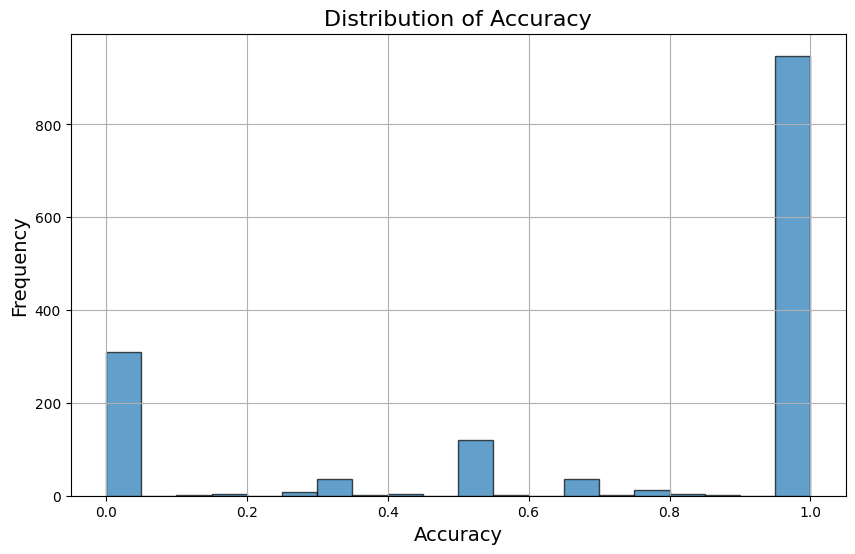

In [21]:
import matplotlib.pyplot as plt

# Plot a histogram of the 'accuracy' column
plt.figure(figsize=(10, 6))
plt.hist(eval_df['accuracy'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


__prompt__ What would be a good way to measure performance in this scenario? I have the number of correct matches in "matches", the number of aspect sentiments that should have been produced in "num_true_aspects" and the number of predicted aspects in "num_pred_aspects". Ideally, the number of correct matches should exactly match "num_true_aspects", and "num_true_aspects" should exactly match "num_pred_aspects".

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision, Recall, and F1 score
precision = eval_df['matches'].sum() / eval_df['num_pred_aspects'].sum()
recall = eval_df['matches'].sum() / eval_df['num_true_aspects'].sum()
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate Match Efficiency
match_efficiency = 1.0 - abs(eval_df['num_pred_aspects'].sum() - eval_df['num_true_aspects'].sum()) / eval_df['num_true_aspects'].sum()

# Print the performance metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Match Efficiency: {match_efficiency:.4f}")

Precision: 0.6754
Recall: 0.6908
F1 Score: 0.6830
Match Efficiency: 0.9771
